In [140]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import matplotlib.cm as cm
import seaborn as sns
sns.set_style("dark")

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture as EM

# Dim reduction
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from scipy.stats import kurtosis 

# Models
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_digits
from utils import learning_curve_plotter, model_param_curve, metrics

In [141]:
seed = 777

In [142]:
# Diabet Load Dataset

diabet_path = "./data/diabetes.csv"
df_diabet = pd.read_csv(diabet_path)

target = 'Outcome'
features = [ 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

X_origin, y = df_diabet[features], df_diabet[target]

# data normalize
sc = MinMaxScaler()
sc.fit(X_origin)

X = sc.transform(X_origin)
X_df = pd.DataFrame(X)
df_diabet = pd.concat([X_df, y], axis=1)

In [143]:
# Load Dataset

mnist = load_digits()

# fig, axes = plt.subplots(2, 10, figsize=(16, 6))
# for i in range(20):
#     axes[i//10, i %10].imshow(mnist.images[i], cmap='gray');
#     axes[i//10, i %10].axis('off')
#     axes[i//10, i %10].set_title(f"target: {mnist.target[i]}")
    
# plt.tight_layout()

# data normalize
sc = MinMaxScaler()
sc.fit(mnist.data)

X = sc.transform(mnist.data)
X_df = pd.DataFrame(X)
y_target = pd.DataFrame(mnist.target)
df_digit = pd.concat([X_df, y_target], axis=1)

In [182]:
def silhouette_plotter(X, num_k, model_nm, title=None):
    
    sil_scores = []
    num_clusters = range(2, num_k+1)
    
    for k in num_clusters:
        cluster_model = model_nm(k, random_state=seed).fit(X)
        pred = cluster_model.predict(X)
        sil_score = silhouette_score(X, pred)
        sil_scores.append(sil_score)

    plt.title(f"Silhoutte Score Plot {title}")
    plt.xticks()
    plt.xlabel("num clusters")
    plt.ylabel("avg. silhouette score")
    plt.grid()
    plt.plot(num_clusters, sil_scores, "-o", color="C1")
    plt.show()
    plt.close()
    
def elbow_plotter(X, num_k, title=None):
    

    num_clusters = range(2, num_k+1)
    kmeans = KMeans()
    visualizer = KElbowVisualizer(kmeans, k=num_clusters)
    visualizer.fit(X)
#     visualizer.title(f"Elbow Curve, {title}")
#     plt.title(f"Elbow Curve, {title}")
    visualizer.show()
    
def plotter(scores, num_k, title_name=None, color=None):
    num_clusters = range(2, num_k+1)
    
    plt.title(title_name)
    plt.xlabel("num clusters")
    plt.ylabel("avg. silhouette score")
    plt.grid()
    plt.plot(num_clusters, scores, "-o", color=color)
    plt.show()
    plt.close()    

def em_scores(X, num_k):
    aic_scores, bic_scores, sil_scores = [], [], []
    num_clusters = range(2, num_k+1)
    
    for k in num_clusters:
        em = EM(n_components=k, warm_start=True, random_state=seed).fit(X)
        pred = em.predict(X)
        sil_score = silhouette_score(X, pred)

        sil_scores.append(sil_score)
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))
        
    return sil_scores, aic_scores, bic_scores

def calc_score_func(X, y, dim=2, mode="None", cv=3):

    nn_clf = MLPClassifier(random_state=seed, max_iter=1000, early_stopping=True, activation="tanh")
    
    if mode == "mlp":
        X_feature = X
    elif mode == "pca":
        pca = PCA(random_state=seed, n_components=dim)
        X_feature = pca.fit_transform(X)
    elif mode == "ica":
        ica = FastICA(random_state=seed, n_components=dim).fit(X)
        X_feature = ica.fit_transform(X)
    elif mode == "rp":
        rp = SparseRandomProjection(random_state=seed, n_components=dim)
        X_feature = rp.fit_transform(X)
    elif mode == "tsvd":
        tsvd = TruncatedSVD(n_components=dim, random_state=seed)
        X_feature = tsvd.fit_transform(X)

    scores = cross_val_score(nn_clf, X_feature, y, scoring="accuracy", cv=cv).mean()
    
    return scores

## Kmeans
- PCA
    - df_diabet: 6
    - df_digit: 22
- ICA
    - df_diabet: 6
    - df_digit: 13
- RP
    - df_diabet: 3
    - df_digit: 28
- TSVD
    - df_diabet: 6
    - df_digit: 20

In [147]:
pca_k_diabet, pca_k_digit = 6, 22
ica_k_diabet, ica_k_digit = 6, 13
rp_k_diabet, rp_k_digit = 3, 28
tsvd_k_diabet, tsvd_k_digit = 6, 20

X_diabet, y_diabet = df_diabet.iloc[:,:-1], df_diabet.iloc[:,-1]
X_digit, y_digit = df_digit.iloc[:,:-1], df_digit.iloc[:,-1]

In [171]:
# Kmeans + PCA
num_k = 15

# pca = PCA(n_components= pca_k_diabet).fit(X_diabet)
# X_pca = pca.transform(X_diabet)

pca = PCA(n_components= pca_k_digit).fit(X_digit)
X_pca = pca.transform(X_digit)

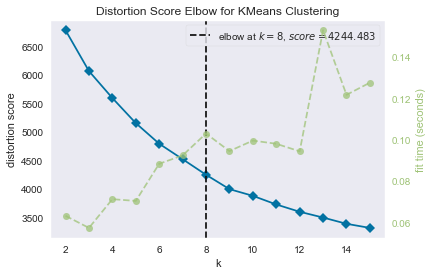

In [172]:
# silhouette_plotter(X_pca, num_k, KMeans, title="K-means + PCA")
# elbow_plotter(X_pca, num_k, title="K-means + PCA")
elbow_plotter(X_pca, num_k, title="K-means + PCA")

In [173]:
# Kmeans + ICA

# ica = FastICA(n_components= ica_k_diabet).fit(X_diabet)
# X_ica = ica.transform(X_diabet)

ica = FastICA(n_components= ica_k_digit).fit(X_digit)
X_ica = ica.transform(X_digit)

/Users/user/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


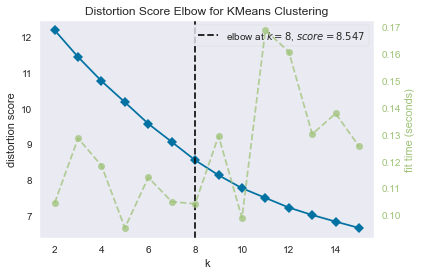

In [174]:
# silhouette_plotter(X_ica, num_k, KMeans, title="K-means + ICA")
elbow_plotter(X_ica, num_k)

In [176]:
# Kmeans + RP

rp = SparseRandomProjection(n_components=rp_k_digit).fit(X_digit)
X_rp = rp.transform(X_digit)

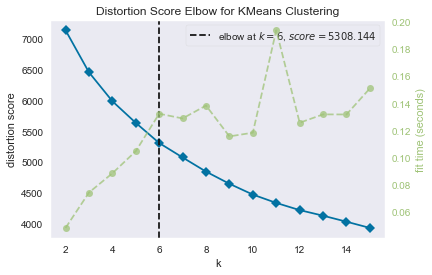

In [177]:
# silhouette_plotter(X_rp, num_k, KMeans)
elbow_plotter(X_rp, num_k)

In [178]:
# Kmeans + tsvd

tsvd = TruncatedSVD(n_components=tsvd_k_digit).fit(X_digit)
X_tsvd = tsvd.transform(X_digit)

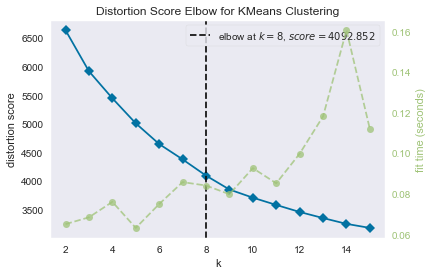

In [179]:
# silhouette_plotter(X_tsvd, num_k, KMeans)
elbow_plotter(X_tsvd, num_k)

## EM
- PCA
    - df_diabet: 3
    - df_digit: 20
- ICA
    - df_diabet: 6
    - df_digit: 13
- RP
    - df_diabet: 2
    - df_digit: 28
- TSVD
    - df_diabet: 3
    - df_digit: 20

In [197]:
# EM + PCA
num_k = 15

# pca = PCA(n_components= pca_k_diabet).fit(X_diabet)
# X_pca = pca.transform(X_diabet)

pca = PCA(n_components= pca_k_digit).fit(X_digit)
X_pca = pca.transform(X_digit)

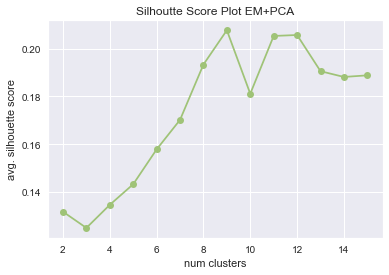

In [198]:
silhouette_plotter(X_pca, num_k, EM, title="EM+PCA")

In [199]:
diabet_scores = em_scores(X_pca, 15)
# digit_scores = em_scores(df_digit)

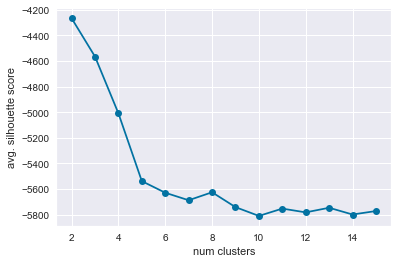

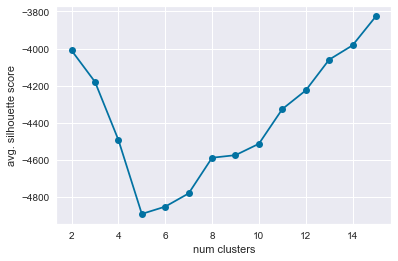

In [185]:
plotter(diabet_scores[1], num_k)
plotter(diabet_scores[2], num_k)

In [200]:
# Kmeans + ICA

ica = FastICA(n_components= ica_k_digit).fit(X_digit)
X_ica = ica.transform(X_digit)

/Users/user/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


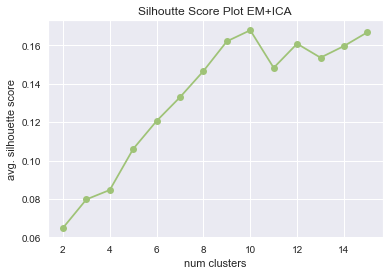

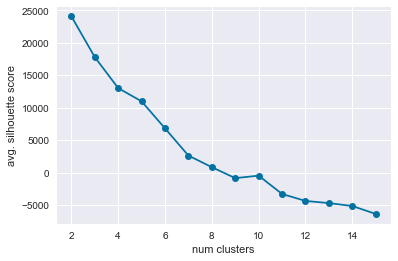

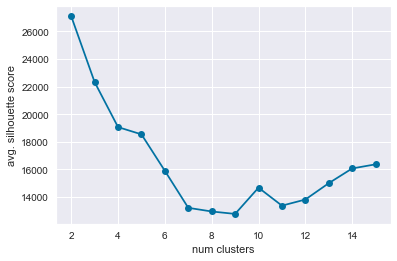

In [201]:
silhouette_plotter(X_ica, num_k, EM, title="EM+ICA")

plotter(diabet_scores[1], num_k)
plotter(diabet_scores[2], num_k)

In [202]:
# Kmeans + RP

rp = SparseRandomProjection(n_components=2).fit(X_digit)
X_rp = rp.transform(X_digit)

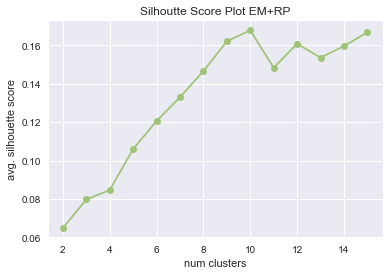

In [203]:
silhouette_plotter(X_ica, num_k, EM, title="EM+RP")

In [205]:
# Kmeans + tsvd

tsvd = TruncatedSVD(n_components=tsvd_k_digit).fit(X_digit)
X_tsvd = tsvd.transform(X_digit)

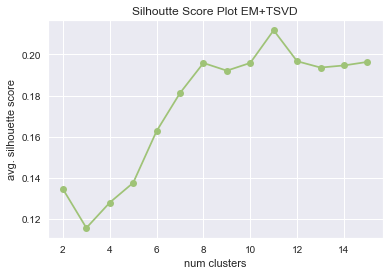

In [206]:
silhouette_plotter(X_tsvd, num_k, EM, title="EM+TSVD")

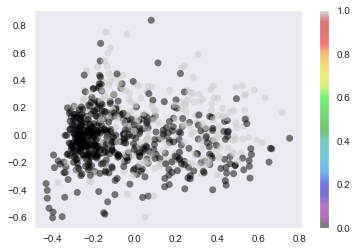

In [139]:
# digits = load_digits()
# pca = PCA(2)  # project from 64 to 2 dimensions
# projected = pca.fit_transform(digits.data)
# print(digits.data.shape)
# print(projected.shape)

# plt.scatter(projected[:, 0], projected[:, 1],
#             c=digits.target, edgecolor='none', alpha=0.5,
#            cmap='nipy_spectral')
# plt.xlabel('component 1')
# plt.ylabel('component 2')
# plt.colorbar();


pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(X_diabet)

plt.scatter(projected[:, 0], projected[:, 1],
            c=y_diabet, edgecolor='none', alpha=0.5,
           cmap='nipy_spectral')
# plt.xlabel('component 1')
# plt.ylabel('component 2')
plt.colorbar();

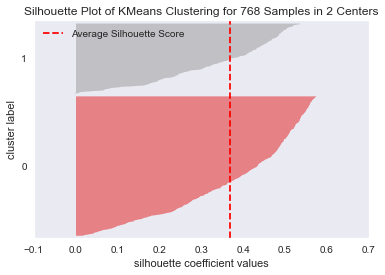

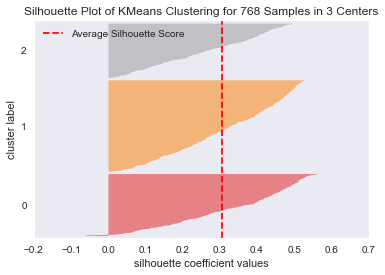

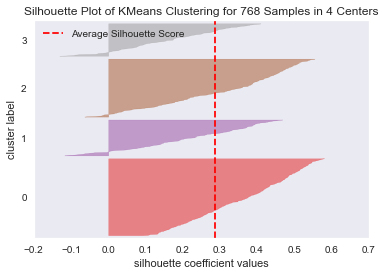

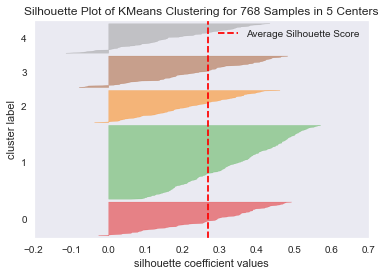

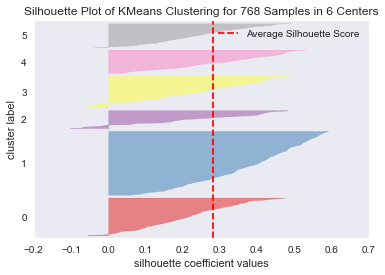

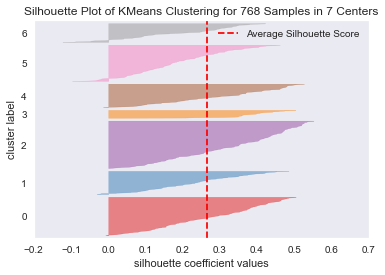

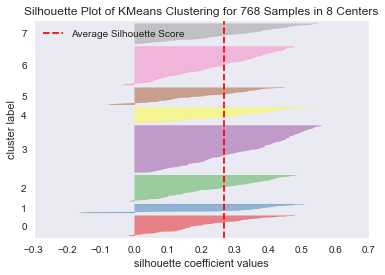

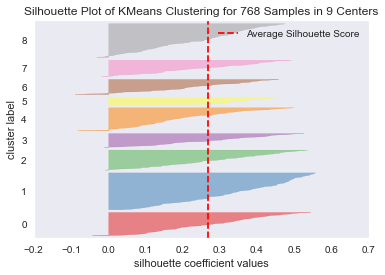

In [114]:
for i in range(2,10):
    kmeans = KMeans(i)
    vis = SilhouetteVisualizer(kmeans)
    vis.fit(X_pca)
    vis.finalize()
    plt.show()
    plt.close()